In this project, we are predicting trends in technology adoption and interest based on social media (Twitter) data. Specifically, the model aims to forecast the following:

1. **Volume of Discussions**: Predicting the number of tweets or social media posts related to specific technologies, gadgets, or software within a given time frame in the future (e.g., daily, weekly). This serves as an indicator of public interest and awareness levels.

2. **Sentiment Trends**: Forecasting the overall sentiment (positive, negative, neutral) associated with these technologies in the social media discourse. This could involve predicting the average sentiment score or the proportion of tweets falling into each sentiment category for upcoming days.

3. **Combination of Volume and Sentiment**: A more comprehensive approach might involve predicting both the volume of discussion and the sentiment concurrently. This dual prediction can provide a more nuanced understanding of how public interest and perception might evolve over time.

### Example Predictions
- **Before a Product Launch**: If there's an upcoming release of a new gadget, the model might predict an increase in the volume of discussion and potentially the sentiment trend leading up to and following the launch.
- **Emerging Technology Trends**: For emerging tech like augmented reality, blockchain, or new software platforms, the model could forecast how discussions (both in volume and sentiment) about these technologies will trend in the short-term future.

### Purpose of These Predictions
- **Market Insight**: These predictions can provide valuable insights for businesses, marketers, and technologists about consumer interest and sentiment trends, aiding in strategic planning and decision-making.
- **Product Strategy**: For tech companies, understanding how public interest and sentiment are likely to shift can inform product development, marketing strategies, and customer engagement plans.
- **Investment Decisions**: Investors in technology sectors might use these predictions to gauge potential market reactions to new technologies or products.

The predictions, therefore, are not just about the raw data but also about interpreting the data to extract meaningful trends and insights that can inform various strategic decisions in the technology domain.

In [1]:
# Essential imports
import pandas as pd
import numpy as np
import tweepy
import nltk
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta

## 1. Data Collection
Sources: Gather data from social media. We will be using Twitter API to search and get tweets with relevant keywords

Keywords: Identify relevant keywords for each technology (e.g., "artificial intelligence", "augmented reality", "blockchain").

In [2]:
# Twitter API keys

# Consumer Keys
# MSML apis
api_key = 'fQyQfxNjgLk8NDoVt339h8K0g'
api_secret_key = '5wHUc4mrkVn1R9pR7tVaNXkKuB6Le1qIpSqKA3nb9H70rEVqiz'

# Authentication Tokens
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJu0rQEAAAAAgyq9jSqX7eeOOvgs2RmwfRHVzgE%3Djo5sGF0vv7XmtfYAgK71rOh70224Z0dmPXFvOrXjekfqJ8XnY3'
access_token = '2931998159-ngeYrsqwmVvs1jYjpZcCFBzO2xm0j2wsqokBLK6'
access_token_secret = 'CGo43zg5cX2KDdyACKDVIUtrULMV1SCBjPVNogCW1UKKs'

# Authenticate
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

client = tweepy.Client(bearer_token=bearer_token, 
              consumer_key=api_key, 
              consumer_secret=api_secret_key, 
              access_token=access_token, 
              access_token_secret=access_token_secret)

In [3]:
# Getting the tweets from twitter
query = 'artificial intelligence -is:retweet'
tweets = client.search_recent_tweets(query=query,
                                  tweet_fields=['context_annotations', 'created_at'],
                                  max_results=100)

# Extract data from the response
data = [{'Tweet': tweet.text, 'Timestamp': tweet.created_at} for tweet in tweets.data]

# Create a DataFrame
tweets_df = pd.DataFrame(data)

# Display the DataFrame
tweets_df.head()

,Tweet,Timestamp
0,I'm excited to be participating and share my e...,2023-12-11 07:28:54+00:00
1,"""ChatGPT, oh ChatGPT\nWith AI so smart\nBut al...",2023-12-11 07:28:14+00:00
2,Engineers at the @UWaterloo harnessed the powe...,2023-12-11 07:27:36+00:00
3,"At present, the accuracy of gunshots varies fr...",2023-12-11 07:26:57+00:00
4,"I can’t predict the future, but I sure can get...",2023-12-11 07:26:55+00:00


In [4]:
def add_tweets_to_database(tweets_df):
    # Create a SQLite database connection
    conn = sqlite3.connect('tweets_database.db')

    # Write the DataFrame to a SQLite table
    tweets_df.to_sql('tweets', conn, if_exists='replace', index=False)

    # Optionally, read the table back from the database to verify
    tweets_df_from_sql = pd.read_sql('SELECT * FROM tweets', conn)

    # Display the DataFrame read from the database
    print(tweets_df_from_sql)

    # Close the database connection
    conn.close()
    
add_tweets_to_database(tweets_df)

                                                Tweet  \
0   I'm excited to be participating and share my e...   
1   "ChatGPT, oh ChatGPT\nWith AI so smart\nBut al...   
2   Engineers at the @UWaterloo harnessed the powe...   
3   At present, the accuracy of gunshots varies fr...   
4   I can’t predict the future, but I sure can get...   
..                                                ...   
95  Large Language Learning Models like #ChatGPT a...   
96  #nowplaying: "TWiT Clip: The EU Artificial Int...   
97  The future of work \n\nisn't remote or in pers...   
98  Victims of Cybertorture, Illegal Neuro Experim...   
99  The Influence of Artificial Intelligence Devel...   

                    Timestamp  
0   2023-12-11 07:28:54+00:00  
1   2023-12-11 07:28:14+00:00  
2   2023-12-11 07:27:36+00:00  
3   2023-12-11 07:26:57+00:00  
4   2023-12-11 07:26:55+00:00  
..                        ...  
95  2023-12-11 06:50:01+00:00  
96  2023-12-11 06:49:06+00:00  
97  2023-12-11 06:49:03+00:

In [5]:
# For fetching the data in the database later
def get_tweets_by_query():
    conn = sqlite3.connect('tweets_database.db')
    cur = conn.cursor()

    # Select tweets that match the query
    cur.execute("SELECT Tweet FROM tweets")
    all_tweets = cur.fetchall()
    
    print(all_tweets)

    conn.close()
    return all_tweets

get_tweets_by_query()

[("I'm excited to be participating and share my experience as one of the Industry AI leaders in the Global Partnership on Artificial Intelligence Summit 2023, which Prime Minister Narendra Modi will inaugurate in New Delhi on 12th Dec at Bharat Mandapam.\n\n@GPAI\xa0#GPAI2023\xa0@GoI_MeitY",), ('"ChatGPT, oh ChatGPT\nWith AI so smart\nBut alas, it’s at capacity\nLeaving us to wait\nFor a chance to chat"\nIn the meantime, read my conversation with Artificial Intellience: ChatGPT https://t.co/aC6DqP7UtZ #amreading #AuthorsOfTwitter',), ('Engineers at the @UWaterloo harnessed the power of artificial intelligence #AI to predict #chemotherapy effectiveness for women with breast cancer before surgery, empowering personalized treatment decisions. 💙 \nRead more now: https://t.co/YPMYtUMjP8 \n#personalizedmedecine https://t.co/LhU63PyIWk',), ('At present, the accuracy of gunshots varies from soldier to soldier. But the new AI tool can suggest when exactly the shot needs to be fired to achieve a

[("I'm excited to be participating and share my experience as one of the Industry AI leaders in the Global Partnership on Artificial Intelligence Summit 2023, which Prime Minister Narendra Modi will inaugurate in New Delhi on 12th Dec at Bharat Mandapam.\n\n@GPAI\xa0#GPAI2023\xa0@GoI_MeitY",),
 ('"ChatGPT, oh ChatGPT\nWith AI so smart\nBut alas, it’s at capacity\nLeaving us to wait\nFor a chance to chat"\nIn the meantime, read my conversation with Artificial Intellience: ChatGPT https://t.co/aC6DqP7UtZ #amreading #AuthorsOfTwitter',),
 ('Engineers at the @UWaterloo harnessed the power of artificial intelligence #AI to predict #chemotherapy effectiveness for women with breast cancer before surgery, empowering personalized treatment decisions. 💙 \nRead more now: https://t.co/YPMYtUMjP8 \n#personalizedmedecine https://t.co/LhU63PyIWk',),
 ('At present, the accuracy of gunshots varies from soldier to soldier. But the new AI tool can suggest when exactly the shot needs to be fired to achiev

## 2. Data Preprocessing
Cleaning: Remove irrelevant content, special characters, and URLs.
Normalization: Convert text to a standard format (e.g., lowercase, stemming).


In [6]:
# Define the tweet cleaning function
def clean_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove @usernames and #hashtags
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Remove punctuation and special characters
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Tokenize the tweet
    tweet_tokens = word_tokenize(tweet)
    
    # Remove stopwords
    filtered_words = [word for word in tweet_tokens if word not in stopwords.words('english')]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    return " ".join(lemmatized_words)

# Assuming tweets_df is your DataFrame and 'Tweet' is the column with tweet texts
# Apply the cleaning function to each tweet
tweets_df['Cleaned_Tweet'] = tweets_df['Tweet'].apply(clean_tweet)

# Display the first few rows of the DataFrame
tweets_df.head()

,Tweet,Timestamp,Cleaned_Tweet
0,I'm excited to be participating and share my e...,2023-12-11 07:28:54+00:00,im excited participating share experience one ...
1,"""ChatGPT, oh ChatGPT\nWith AI so smart\nBut al...",2023-12-11 07:28:14+00:00,chatgpt oh chatgpt ai smart ala capacity leavi...
2,Engineers at the @UWaterloo harnessed the powe...,2023-12-11 07:27:36+00:00,engineer harnessed power artificial intelligen...
3,"At present, the accuracy of gunshots varies fr...",2023-12-11 07:26:57+00:00,present accuracy gunshot varies soldier soldie...
4,"I can’t predict the future, but I sure can get...",2023-12-11 07:26:55+00:00,cant predict future sure get pretty close take...


In [7]:
# Drop the 'ContextAnnotations' column
tweets_df = tweets_df.drop('Tweet', axis=1)

# Display the DataFrame to confirm the column is dropped
tweets_df.head()

,Timestamp,Cleaned_Tweet
0,2023-12-11 07:28:54+00:00,im excited participating share experience one ...
1,2023-12-11 07:28:14+00:00,chatgpt oh chatgpt ai smart ala capacity leavi...
2,2023-12-11 07:27:36+00:00,engineer harnessed power artificial intelligen...
3,2023-12-11 07:26:57+00:00,present accuracy gunshot varies soldier soldie...
4,2023-12-11 07:26:55+00:00,cant predict future sure get pretty close take...


In [8]:
# If the tweet does not contain the keywords then remove it

# query words
query_words = ['Artificial Intelligence', 'ai']

# Create a boolean mask
mask = tweets_df['Cleaned_Tweet'].str.contains('|'.join(query_words), case=False, na=False)

# Filter the DataFrame
filtered_tweets_df = tweets_df[mask]

# Display the filtered DataFrame
filtered_tweets_df.head()

,Timestamp,Cleaned_Tweet
0,2023-12-11 07:28:54+00:00,im excited participating share experience one ...
1,2023-12-11 07:28:14+00:00,chatgpt oh chatgpt ai smart ala capacity leavi...
2,2023-12-11 07:27:36+00:00,engineer harnessed power artificial intelligen...
3,2023-12-11 07:26:57+00:00,present accuracy gunshot varies soldier soldie...
4,2023-12-11 07:26:55+00:00,cant predict future sure get pretty close take...


## 3. Sentiment Analysis
Sentiment Detection Tool: Use pre-built libraries like TextBlob.
Classification: Classify the sentiment of each piece of text as positive, negative, or neutral.

In [9]:
# Function to apply sentiment analysis
def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive', polarity
    elif polarity == 0:
        return 'neutral', polarity
    else:
        return 'negative', polarity

# Apply the function to each tweet
tweets_df['Sentiment'], tweets_df['Polarity'] = zip(*tweets_df['Cleaned_Tweet'].apply(analyze_sentiment))

# Display the first few rows of the DataFrame with sentiment data
tweets_df.head()

,Timestamp,Cleaned_Tweet,Sentiment,Polarity
0,2023-12-11 07:28:54+00:00,im excited participating share experience one ...,negative,-0.022159
1,2023-12-11 07:28:14+00:00,chatgpt oh chatgpt ai smart ala capacity leavi...,negative,-0.192857
2,2023-12-11 07:27:36+00:00,engineer harnessed power artificial intelligen...,negative,-0.600000
3,2023-12-11 07:26:57+00:00,present accuracy gunshot varies soldier soldie...,negative,-0.015455
4,2023-12-11 07:26:55+00:00,cant predict future sure get pretty close take...,positive,0.130000


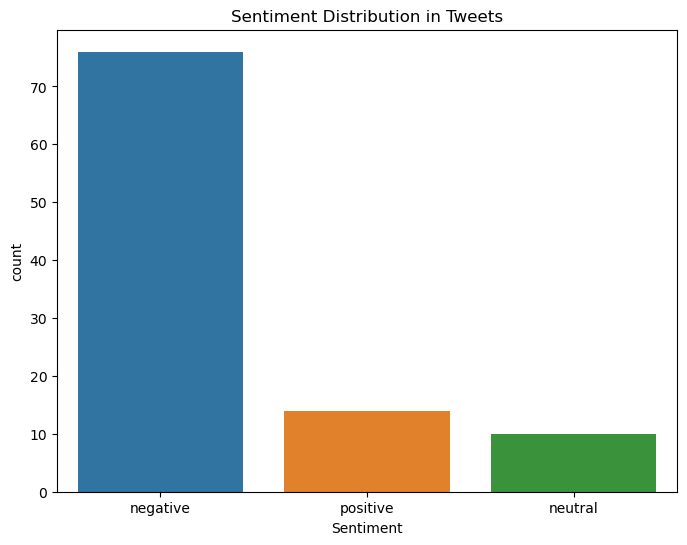

In [10]:
# Ensure your DataFrame has 'Sentiment' column from the sentiment analysis step
# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=tweets_df)
plt.title('Sentiment Distribution in Tweets')
plt.show()

C:\Users\mamad\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
C:\Users\mamad\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
C:\Users\mamad\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


<Figure size 1000x600 with 0 Axes>

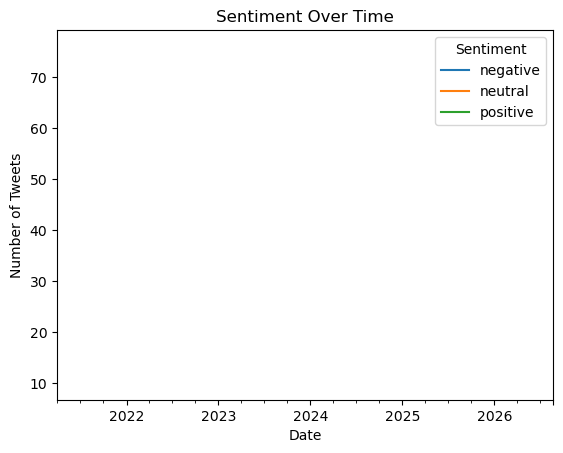

In [11]:
# Sentiment Over Time (assuming there's a 'Timestamp' column)
# Convert 'Timestamp' to datetime if not already
tweets_df['Timestamp'] = pd.to_datetime(tweets_df['Timestamp'])
plt.figure(figsize=(10, 6))
tweets_df.resample('D', on='Timestamp')['Sentiment'].value_counts().unstack().plot(kind='line')
plt.title('Sentiment Over Time')
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.show()

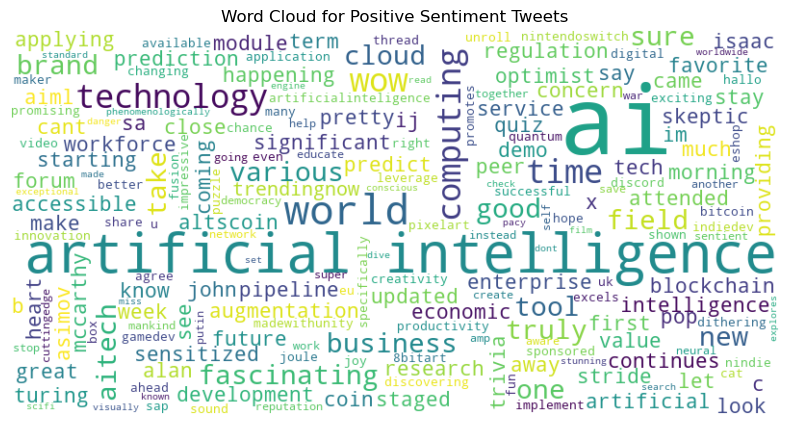

In [12]:
# Word Cloud (for positive sentiment tweets as an example)
positive_tweets = ' '.join(tweets_df[tweets_df['Sentiment'] == 'positive']['Cleaned_Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(positive_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

In [13]:
if tweets_df['Sentiment'].dtype == 'object':
    tweets_df['Sentiment'] = tweets_df['Sentiment'].astype('category')

## 4. Time Series Analysis
Aggregation: Aggregate sentiment scores over time (daily, weekly).
Trends Analysis: Use time series analysis techniques to identify trends. Libraries like Pandas and statsmodels can be helpful.


C:\Users\mamad\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


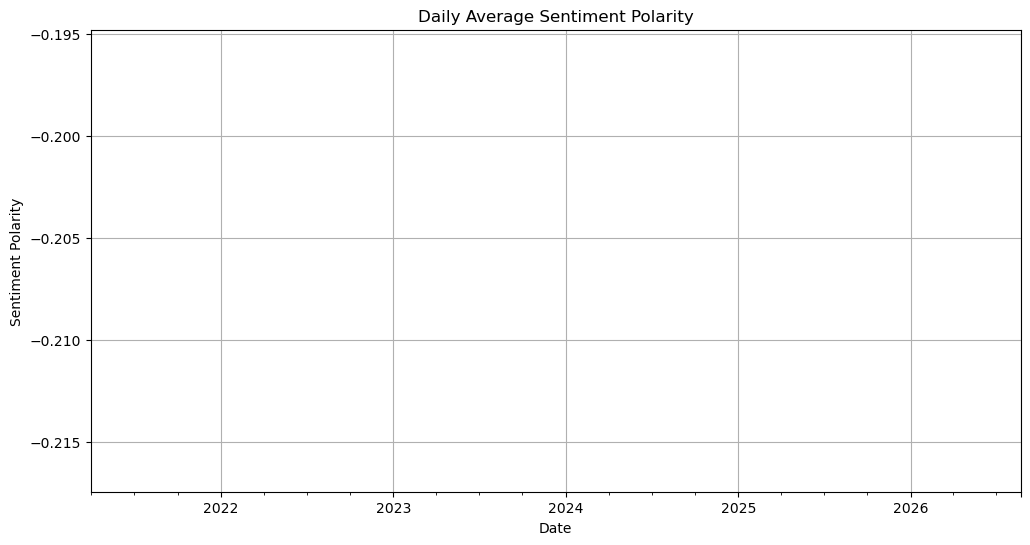

ValueError: Invalid input, x is constant

In [14]:
# Convert 'Timestamp' to datetime and set as index
tweets_df['Timestamp'] = pd.to_datetime(tweets_df['Timestamp'])
tweets_df.set_index('Timestamp', inplace=True)

# Resample and aggregate sentiment scores
# For example, calculating daily mean sentiment
daily_sentiment = tweets_df['Polarity'].resample('D').mean()

# Plot daily sentiment
plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title('Daily Average Sentiment Polarity')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

# Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(daily_sentiment.dropna())
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

# Interpret the results (using a typical p-value threshold of 0.05)
if adf_test[1] < 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

## 5. Forecasting
Model Selection: Choose a forecasting model like ARIMA, SARIMA, or LSTM (for deep learning approaches).
Prediction: Use the model to predict future trends in sentiment and discussion volume.


## 6. Visualization
Tools: Use libraries like Matplotlib or Plotly to visualize trends and forecasts.
Dashboard: Consider building a dashboard using Dash or Streamlit for real-time analysis and visualization.


## 7. Continuous Improvement and Updating
Feedback Loop: Incorporate new data regularly to update the models.
Model Tuning: Continuously evaluate and tune the models for better accuracy.


## 8. Deployment
Web Application: Deploy as a web application using frameworks like Flask or Django.
APIs: Create APIs for accessing the analysis and forecasts.